# 3.1 Tree construction

- **Pros**: Computationally cheap to use, easy for humans to understand learned results,missing values OK, can deal with irrelevant features
- **Cons**: Prone to overfitting
- **Works with**: Numeric values, nominal values

In [15]:
import math
import operator
import matplotlib.pyplot as plt
import pickle

### 3.1.1 Information gain

In [7]:
def calcShannonEntropy(dataSet):
    """
    Calculate the Shannon entropy of a dataset.
    
    :param dataSet: List of lists containing the dataset
    :return: Shannon entropy value
    """
    numEntries = len(dataSet)
    labelCounts = {}
    
    # Count occurrences of each label
    for featVec in dataSet:
        currentLabel = featVec[-1]
        if currentLabel not in labelCounts:
            labelCounts[currentLabel] = 0
        labelCounts[currentLabel] += 1
    
    # Calculate the entropy
    shannonEntropy = 0.0
    for key in labelCounts:
        prob = float(labelCounts[key]) / numEntries
        shannonEntropy -= prob * math.log(prob, 2)
    
    return shannonEntropy
    
    
def createDataSet():
    """
    Create a sample dataset with labels and features.
    
    :return: Tuple of dataset and labels
    """
    dataSet = [[1, 1, 'maybe'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no'], [0, 0, 'no']]
    labels = ['no surfacing', 'flippers']
    return dataSet, labels

myDataSet, myLabels = createDataSet()
print("Sample dataset:", myDataSet)
print("Sample labels:", myLabels)

# Example usage of calcShannonEntropy
entropy = calcShannonEntropy(myDataSet)
print("Shannon entropy of the dataset:", entropy)


Sample dataset: [[1, 1, 'maybe'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no'], [0, 0, 'no']]
Sample labels: ['no surfacing', 'flippers']
Shannon entropy of the dataset: 1.2516291673878228


### 3.1.2 Splitting the dataset

In [8]:
def splitDataSet(dataSet, axis, value):
    """
    Split the dataset based on a feature and its value.
    
    :param dataSet: List of lists containing the dataset
    :param axis: Index of the feature to split on
    :param value: Value of the feature to split on
    :return: Subset of the dataset that matches the split criteria
    """
    retDataSet = []
    for featVec in dataSet:
        if featVec[axis] == value:
            # print("Splitting on feature index:", axis, "with value:", value , "->", featVec)
            reducedFeatVec = featVec[:axis] + featVec[axis+1:]
            retDataSet.append(reducedFeatVec)
    return retDataSet

# splitDataSet(myDataSet, 0, 1)

def chooseBestFeatureToSplit(dataSet):
    """
    Choose the best feature to split the dataset based on information gain.
    
    :param dataSet: List of lists containing the dataset
    :return: Index of the best feature to split on
    """
    numFeatures = len(dataSet[0]) - 1  # Exclude label column
    baseEntropy = calcShannonEntropy(dataSet)
    bestInfoGain = 0.0
    bestFeature = -1
    
    for i in range(numFeatures):
        # Get unique values for the feature
        featList = [example[i] for example in dataSet]
        uniqueVals = set(featList)
        
        newEntropy = 0.0
        for value in uniqueVals:
            subDataSet = splitDataSet(dataSet, i, value)
            prob = len(subDataSet) / float(len(dataSet))
            newEntropy += prob * calcShannonEntropy(subDataSet)
        
        infoGain = baseEntropy - newEntropy
        
        if infoGain > bestInfoGain:
            bestInfoGain = infoGain
            bestFeature = i
    
    return bestFeature

print("Best feature to split on:", chooseBestFeatureToSplit(myDataSet))

Best feature to split on: 0


### 3.1.3 Recursively building the tree

In [9]:
def majorityCnt(classList):
    """
    Get the majority class from a list of classes.
    
    :param classList: List of classes
    :return: Majority class
    """
    classCount = {}
    for vote in classList:
        if vote not in classCount:
            classCount[vote] = 0
        classCount[vote] += 1
    
    sortedClassCount = sorted(classCount.items(), key=operator.itemgetter(1), reverse=True)
    return sortedClassCount[0][0]

def createTree(dataSet, labels):
    """
    Create a decision tree from the dataset.
    
    :param dataSet: List of lists containing the dataset
    :param labels: List of feature labels
    :return: Decision tree as a nested dictionary
    """
    classList = [example[-1] for example in dataSet]
    
    # If all classes are the same, return that class
    if classList.count(classList[0]) == len(classList):
        return classList[0]
    
    # If no features left, return majority class
    if len(dataSet[0]) == 1:
        return majorityCnt(classList)
    
    # Choose the best feature to split on
    bestFeat = chooseBestFeatureToSplit(dataSet)
    bestFeatLabel = labels[bestFeat]
    
    # Create the tree structure
    myTree = {bestFeatLabel: {}}
    
    # Remove the feature from the labels list for further splits
    del(labels[bestFeat])
    
    # Get unique values for the best feature
    featValues = [example[bestFeat] for example in dataSet]
    uniqueVals = set(featValues)
    
    for value in uniqueVals:
        subLabels = labels[:]  # Copy remaining labels
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet, bestFeat, value), subLabels)
    
    return myTree

print("Decision tree structure:" , createTree(myDataSet, myLabels[:]))

Decision tree structure: {'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'maybe'}}}}


# 3.2 Plotting trees in Python with Matplotlib annotations

### 3.2.1 Matplotlib annotations

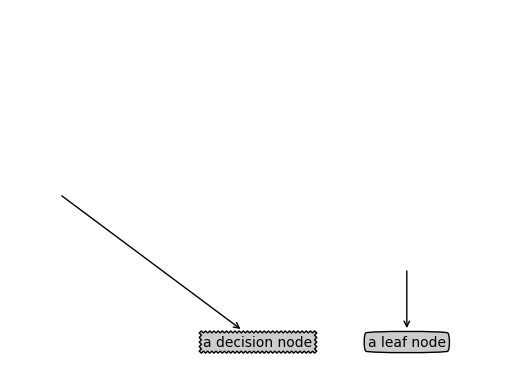

In [10]:
decisionNode = dict(boxstyle="sawtooth", fc="0.8")
leafNode = dict(boxstyle="round4", fc="0.8")
arrow_args = dict(arrowstyle="<-")

def plotNode(nodeTxt, centerPt, parentPt, nodeType, arrow_args):
    """
    Plot a node in the decision tree.
    
    :param nodeTxt: Text to display in the node
    :param centerPt: Center point of the node
    :param parentPt: Parent point of the node
    :param nodeType: Type of node (decision or leaf)
    :param arrow_args: Arguments for the arrow style
    """
    createPlot.ax1.annotate(nodeTxt, xy=parentPt, xycoords='axes fraction', xytext=centerPt,
                            textcoords='axes fraction', va="center", ha="center", bbox=nodeType,
                            arrowprops=arrow_args)
    
def createPlot(inTree):
    """
    Create a plot of the decision tree.
    
    :param inTree: Decision tree structure
    """
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)  # no ticks
    plotNode('a decision node', (0.5, 0.1), (0.1, 0.5), decisionNode, arrow_args)
    plotNode('a leaf node', (0.8, 0.1), (0.8, 0.3), leafNode, arrow_args)
    plt.show()
    
createPlot(inTree=None)

### 3.2.2 Constructing a tree of annotations

In [11]:
def getNumLeafs(myTree):
    """
    Get the number of leaf nodes in the decision tree.
    
    :param myTree: Decision tree structure
    :return: Number of leaf nodes
    """
    numLeafs = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    
    for key in secondDict.keys():
        if isinstance(secondDict[key], dict):
            numLeafs += getNumLeafs(secondDict[key])
        else:
            numLeafs += 1
    
    return numLeafs

def getTreeDepth(myTree):
    """
    Get the depth of the decision tree.
    
    :param myTree: Decision tree structure
    :return: Depth of the tree
    """
    maxDepth = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    
    for key in secondDict.keys():
        if isinstance(secondDict[key], dict):
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:
            thisDepth = 1
        if thisDepth > maxDepth:
            maxDepth = thisDepth
    
    return maxDepth

def retrieveTree(i):
    """
    Retrieve a pre-defined decision tree structure.
    
    :param i: Index of the tree to retrieve
    :return: Decision tree structure
    """
    listOfTrees = [{'no surfacing': {0: 'no', 1: {'flippers': \
                    {0: 'no', 1: 'yes'}}}},
                    {'no surfacing': {0: 'no', 1: {'flippers': \
                    {0: {'head': {0: 'no', 1: 'yes'}}, 1: 'no'}}}}]
    return listOfTrees[i]

myTree = retrieveTree(0)

print("Number of leaf nodes in the tree:", getNumLeafs(myTree))
print("Depth of the tree:", getTreeDepth(myTree))   

Number of leaf nodes in the tree: 3
Depth of the tree: 2


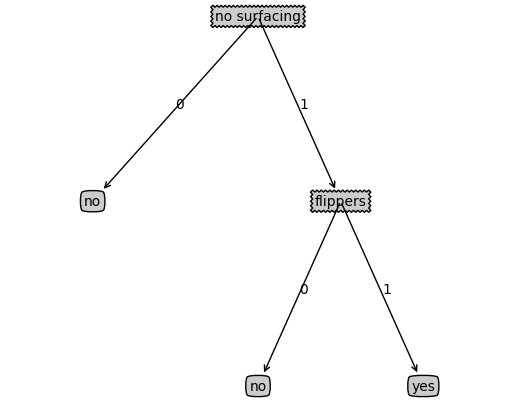

In [12]:
def plotMidText(cntrPt, parentPt, txtString):
    """
    Plot text in the middle of a line connecting two points.
    
    :param cntrPt: Center point of the text
    :param parentPt: Parent point of the text
    :param txtString: Text to display
    """
    xMid = (parentPt[0] - cntrPt[0]) / 2.0 + cntrPt[0]
    yMid = (parentPt[1] - cntrPt[1]) / 2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString)
    
def plotTree(myTree, parentPt, nodeTxt):
    """
    Plot the decision tree recursively.
    
    :param myTree: Decision tree structure
    :param parentPt: Parent point of the current node
    :param nodeTxt: Text to display in the current node
    """
    numLeafs = getNumLeafs(myTree)
    depth = getTreeDepth(myTree)
    
    firstStr = list(myTree.keys())[0]
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs)) / 2.0 / plotTree.totalW, plotTree.yOff)
    
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, decisionNode, arrow_args)
    
    secondDict = myTree[firstStr]
    plotTree.yOff -= 1.0 / plotTree.totalD
    
    for key in secondDict.keys():
        if isinstance(secondDict[key], dict):
            plotTree(secondDict[key], cntrPt, str(key))
        else:
            plotTree.xOff += 1.0 / plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode, arrow_args)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    
    plotTree.yOff += 1.0 / plotTree.totalD
    
def createPlot(inTree):
    """
    Create a plot of the decision tree.
    
    :param inTree: Decision tree structure
    """
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)  # no ticks
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5 / plotTree.totalW
    plotTree.yOff = 1.0
    plotTree(inTree, (0.5, 1.0), '')
    plt.show()
    
createPlot(myTree)

# 3.3 Testing and storing the classifier

### 3.3.1 Test: using the tree for classification

In [14]:
def classify(inputTree, featLabels, testVec):
    """
    Classify a new instance using the decision tree.
    
    :param inputTree: Decision tree structure
    :param featLabels: List of feature labels
    :param testVec: Feature vector of the instance to classify
    :return: Predicted class label
    """
    firstStr = list(inputTree.keys())[0]
    secondDict = inputTree[firstStr]
    
    featIndex = featLabels.index(firstStr)
    
    for key in secondDict.keys():
        if isinstance(secondDict[key], dict):
            classLabel = classify(secondDict[key], featLabels, testVec)
        else:
            if testVec[featIndex] == key:
                classLabel = secondDict[key]
    
    return classLabel

print("Predicted class for test vector [1, 1]:", classify(myTree, myLabels, [1, 1]))
print("Predicted class for test vector [0, 0]:", classify(myTree, myLabels, [0, 0]))

Predicted class for test vector [1, 1]: yes
Predicted class for test vector [0, 0]: no


### 3.3.2 Use: persisting the decision tree

In [17]:
import json
def storeTree(inputTree, filename):
    """
    Store the decision tree to a readable text file using UTF-8 encoding.
    
    :param inputTree: Decision tree structure
    :param filename: Name of the file to store the tree
    """
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(inputTree, f, ensure_ascii=False, indent=4)
        
def grabTree(filename):
    """
    Retrieve the decision tree from a readable text file stored in UTF-8 encoding.
    
    :param filename: Name of the file to retrieve the tree from
    :return: Decision tree structure
    """
    with open(filename, 'r', encoding='utf-8') as f:
        return json.load(f)
    
storeTree(myTree, 'classifierStorage.txt')
print("Stored tree:", myTree)
print("Retrieved tree:", grabTree('classifierStorage.txt'))

Stored tree: {'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}
Retrieved tree: {'no surfacing': {'0': 'no', '1': {'flippers': {'0': 'no', '1': 'yes'}}}}


# 3.4 Example: using decision trees to predict contact lens type

Lenses decision tree structure: {'tearRate': {'reduced': 'no lenses', 'normal': {'astigmatic': {'yes': {'prescript': {'myope': 'hard', 'hyper': {'age': {'presbyopic': 'no lenses', 'young': 'hard', 'pre': 'no lenses'}}}}, 'no': {'age': {'presbyopic': {'prescript': {'myope': 'no lenses', 'hyper': 'soft'}}, 'young': 'soft', 'pre': 'soft'}}}}}}


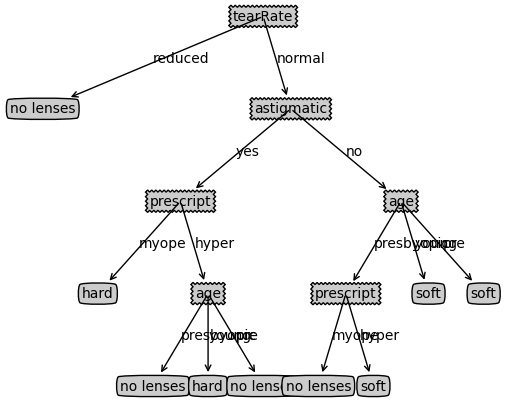

In [18]:
fr = open('lenses.txt', 'r')
lenses = [line.strip().split('\t') for line in fr.readlines()]
lensesLabels = ['age', 'prescript', 'astigmatic', 'tearRate']
lensesTree = createTree(lenses, lensesLabels[:])
print("Lenses decision tree structure:", lensesTree)
createPlot(lensesTree)
fr.close()